In [1]:
import pandas as pd
import numpy as np
import math
import pickle
from sqlalchemy import create_engine
from matplotlib import pyplot as plt

In [2]:
# データベースの情報
server = 'gciteam16.database.windows.net'
database = 'mynavi-database'
username = 'gciteam16'
password = 'Password0'
port =1433

In [3]:
# 接続エンジンの作成
engine_config = "?driver=ODBC+Driver+13+for+SQL+Server?charset=shift-jis"
db_settings = {
    "host": server,
    "database": database,
    "user": username,
    "password": password,
    "port":port,
    "config_query":engine_config
}
engine = create_engine('mssql+pyodbc://{user}:{password}@{host}:{port}/{database}{config_query}'.format(**db_settings))

In [4]:
query = "SELECT * FROM analytical_data_table"
analytical_data = pd.read_sql(query, con=engine)

In [5]:
#with open('../../gci_project_storage/analytical_data.pickle', mode='rb') as f:
#     analytical_data = pickle.load(f)

# 分析データの確認

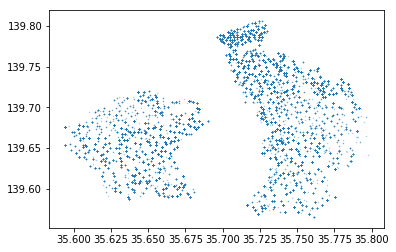

In [147]:
# 場所をプロット
plt.scatter(analytical_data.address_lat, analytical_data.address_lng,s=0.2,alpha=0.4)
plt.show()

<h3>データ整形

In [5]:
analytical_data = analytical_data.reindex(np.random.permutation(analytical_data.index))

In [6]:
X = analytical_data.iloc[:,3:]
y = analytical_data.iloc[:,:3].rent

<h3>交差検証

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.cross_validation import cross_val_score

models = [
    LinearRegression()
    ,Lasso(alpha=0.05)
    ,Lasso(alpha=0.1)
    ,Lasso(alpha=0.2)
    ,Ridge(alpha=0.05)
    ,Ridge(alpha=0.1)
    ,Ridge(alpha=0.2)
    ,RandomForestRegressor(n_estimators=100)
    ,LinearSVR()
    ]

C:\Anaconda\envs\py35\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [156]:
for model in models:
    scores = cross_val_score(model, X, y,cv=4)
    print(model.__class__.__name__, "   \tscores:\t", scores )

LinearRegression    	scores:	 [ 0.78194568  0.80491104  0.81293948  0.83214763]
Lasso    	scores:	 [ 0.71108627  0.73030789  0.76724052  0.76814043]
Lasso    	scores:	 [ 0.70000653  0.71853667  0.76049695  0.75916611]
Lasso    	scores:	 [ 0.69082459  0.70501728  0.75517947  0.75018223]
Ridge    	scores:	 [ 0.78211344  0.80556406  0.81276457  0.83494342]
Ridge    	scores:	 [ 0.78214145  0.80565627  0.81216862  0.83617512]
Ridge    	scores:	 [ 0.78210725  0.80561932  0.8111891   0.83771443]
RandomForestRegressor    	scores:	 [ 0.86531195  0.8586472   0.94215341  0.94436866]
LinearSVR    	scores:	 [ 0.68507747  0.71285068  0.73260475  0.75586104]


<h3>重要度を確認

In [157]:
model_r = RandomForestRegressor(n_estimators=200)
model_r.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [273]:
importance = pd.Series(model_r.feature_importances_,index=X.columns)
print("駅の重要度合計：",importance[145:].sum())
print("間取りの重要度合計：",importance[50:55].sum())
print(importance.sort_values(ascending=False))

駅の重要度合計： 0.0668912492262
間取りの重要度合計： 0.0013211907461
area                                7.223198e-01
address_lat                         5.000768e-02
year_built                          4.205656e-02
address_lng                         3.268858e-02
auto_lock                           2.242833e-02
渋谷駅                                 2.176416e-02
buildings_height_Null_to_Zero       9.735601e-03
恵比寿駅                                8.978834e-03
refrigerator_Null_to_Zero           7.050143e-03
表参道駅                                5.743465e-03
total_units_Null_to_Zero            4.873921e-03
locality_Null_to_Zero               4.341902e-03
代々木公園駅                              4.103995e-03
明治神宮前駅                              3.038036e-03
bath_drier_Null_to_Zero             2.848468e-03
原宿駅                                 1.977428e-03
structure                           1.837844e-03
代々木八幡駅                              1.637615e-03
北参道駅                                1.587095e-03
top_floor        

<h3>緯度経度で決定木どれだけ精度出せるか確認

In [83]:
from sklearn.tree import DecisionTreeRegressor
X_place = analytical_data[["address_lat","address_lng"]]
model_toy = DecisionTreeRegressor()
model_toy.fit(X_place.iloc[:20000,:],y[:20000])
print(model_toy.score(X_place.iloc[20000:,:],y[20000:]))

0.251574482003


<h3>最も高い駅を見つける

In [163]:
model_toy2 = Ridge(alpha=0.1)
model_toy2.fit(X,y)
coefficients = pd.Series(model_toy2.coef_,index=X.columns)[145:].sort_values(ascending=False)
print(coefficients[:10])

表参道駅      50.882314
明治神宮前駅    33.629521
代々木公園駅    32.165754
広尾駅       27.795953
恵比寿駅      16.995465
渋谷駅       13.489225
富士見ケ丘駅    11.618275
飯田橋駅       9.405590
参宮橋駅       8.027077
代官山駅       7.988365
dtype: float64


<h3>残差の可視化

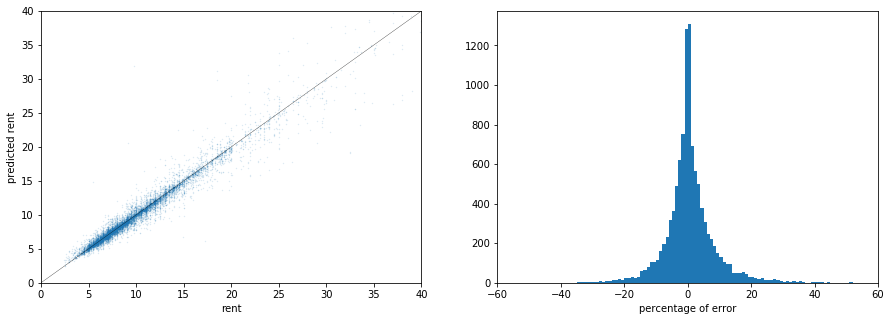

In [200]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
#model_r_20000 = RandomForestRegressor(n_estimators=300)
#model_r_20000.fit(X.iloc[:20000,:],y[:20000])
#y_pred_20000 = model_r_20000.predict(X.iloc[20000:,:])
plt.scatter(x=y[20000:],y=y_pred_20000,s=0.1,alpha=0.2)
plt.xlim(0,40)
plt.ylim(0,40)
plt.xlabel("rent")
plt.ylabel("predicted rent")
plt.plot([0,40],[0,40],c="black",linewidth=0.3)
plt.subplot(1,2,2)
plt.hist((y_pred_20000/y[20000:]-1)*100, bins=range(-60,60))
plt.xlim(-60,60)
plt.xlabel("percentage of error")
plt.show()

<h3>お買い得物件の検索

In [271]:
print("割高な物件の平均価格",y[20000:][(y[20000:]-y_pred_20000)>0].mean())
print("割安な物件の平均価格",y[20000:][(y[20000:]-y_pred_20000)<0].mean())

割高な物件の平均価格 10.985770781340044
割安な物件の平均価格 9.280634367628437


In [268]:
(y[20000:]-y_pred_20000).var()**(1/2)

1.3142825712401214

In [201]:
percentage_price_pred = 100*(y_pred_20000/y[20000:]).sort_values(ascending=False)

In [272]:
index_bad_price = percentage_price_pred.sort_values(ascending=True).index
print("割高な物件")
for i in index_bad_price[0:50]:
    print(list(analytical_data.url[X.index==i])[0]
          ,list(analytical_data.rent[X.index==i])[0]
          ,"万円　相場の"
          ,(y[i]/model_r_20000.predict(X[X.index==i])[0])*100
          ,"％の価格！")
index_good_price = percentage_price_pred.sort_values(ascending=False).index
print("お買い得物件")
for i in index_good_price[0:50]:
    if list(analytical_data.rent[X.index==i])[0]<10:
        print(list(analytical_data.url[X.index==i])[0]
              ,list(analytical_data.rent[X.index==i])[0]
              ,"万円　相場の"
              ,(y[i]/model_r_20000.predict(X[X.index==i])[0])*100
              ,"％の価格！")

割高な物件
https://chintai.mynavi.jp/tokyo/116/room2500008925.html 17.3 万円　相場の 280.510215112 ％の価格！
https://chintai.mynavi.jp/tokyo/116/room608500007811.html 14.9 万円　相場の 220.408767042 ％の価格！
https://chintai.mynavi.jp/tokyo/112/room3395500002811.html 32.5 万円　相場の 170.403900939 ％の価格！
https://chintai.mynavi.jp/tokyo/112/room4372600003328.html 32.5 万円　相場の 168.451969592 ％の価格！
https://chintai.mynavi.jp/tokyo/112/room2526200000307.html 70.0 万円　相場の 161.678251042 ％の価格！
https://chintai.mynavi.jp/tokyo/116/room3400008925.html 15.0 万円　相場の 153.38730294 ％の価格！
https://chintai.mynavi.jp/tokyo/116/room715500004190.html 13.7 万円　相場の 151.59394952 ％の価格！
https://chintai.mynavi.jp/tokyo/120/room143600004373.html 25.0 万円　相場の 149.929533119 ％の価格！
https://chintai.mynavi.jp/tokyo/113/room562000000205.html 62.0 万円　相場の 149.551586453 ％の価格！
https://chintai.mynavi.jp/tokyo/112/room998300004243.html 60.0 万円　相場の 148.9585316 ％の価格！
https://chintai.mynavi.jp/tokyo/120/room135000007258.html 9.0 万円　相場の 148.805423131 ％の価格！
https://ch

In [260]:
analytical_data.year_built.mean()

1999.5950598802394

In [253]:
import urllib
import re
import time

def is_404(url):
    time.sleep(3)
    try:
        uh = urllib.request.urlopen(url)
        return False
    except urllib.error.HTTPError as err:
        if err.code == 404:
            return True
        else:
            raise

In [257]:
good_404 = "割安物件は、100件中{}件が、掲載終了".format(analytical_data.url[index_good_price[:100]].apply(is_404).sum())
bad_404 = "割高物件は、100件中{}件が、掲載終了".format(analytical_data.url[index_bad_price[:100]].apply(is_404).sum())

In [258]:
print(good_404)
print(bad_404)

割安物件は、100件中55件が、掲載終了
割高物件は、100件中50件が、掲載終了


<h3>実装用の予測モデルの作成

In [8]:
X_avoid_0_to_7682 = X.iloc[pd.Series(range(7682,30728)),:]
X_avoid_7682_to_15364 = X.iloc[pd.Series(list(range(0,7682))+list(range(15364,30728))),:]
X_avoid_15364_to_23046 = X.iloc[pd.Series(list(range(0,15364))+list(range(23046,30728))),:]
X_avoid_23046_to_30728 = X.iloc[pd.Series(range(0,23046)),:]

y_avoid_0_to_7682 = y[pd.Series(range(7682,30728))]
y_avoid_7682_to_15364 = y[pd.Series(list(range(0,7682))+list(range(15364,30728)))]
y_avoid_15364_to_23046 = y[pd.Series(list(range(0,15364))+list(range(23046,30728)))]
y_avoid_23046_to_30728 = y[pd.Series(range(0,23046))]

RF_avoid_0_to_7682 = RandomForestRegressor(n_estimators=100).fit(X_avoid_0_to_7682,y_avoid_0_to_7682)
RF_avoid_7682_to_15364 = RandomForestRegressor(n_estimators=100).fit(X_avoid_7682_to_15364,y_avoid_7682_to_15364)
RF_avoid_15364_to_23046 = RandomForestRegressor(n_estimators=100).fit(X_avoid_15364_to_23046,y_avoid_15364_to_23046)
RF_avoid_23046_to_30728 = RandomForestRegressor(n_estimators=100).fit(X_avoid_23046_to_30728,y_avoid_23046_to_30728)
RF_whole_data = RandomForestRegressor(n_estimators=100).fit(X,y)
RF_models = {
    "RF_avoid_0_to_7682":RF_avoid_0_to_7682
    ,"RF_avoid_7682_to_15364":RF_avoid_7682_to_15364
    ,"RF_avoid_15364_to_23046":RF_avoid_15364_to_23046
    ,"RF_avoid_23046_to_30728":RF_avoid_23046_to_30728
    ,"RF_whole_data":RF_whole_data
}

In [9]:
with open('../../gci_project_storage/RF_models.pickle', mode='wb') as f:
     pickle.dump(RF_models, f)

In [10]:
train_data_urls = analytical_data.url

In [11]:
with open('../../gci_project_storage/train_data_urls.pickle', mode='wb') as f:
     pickle.dump(train_data_urls, f)

In [25]:
print("fin.")

fin.
